In [272]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score

In [273]:
EPOCHS = 5
BATCH_SIZE = 16
LEARNING_RATE = 3e-4
HIDDEN_DIM = 64
KERNEL_DIM = 3
POOL_DIM = 2

In [274]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [275]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

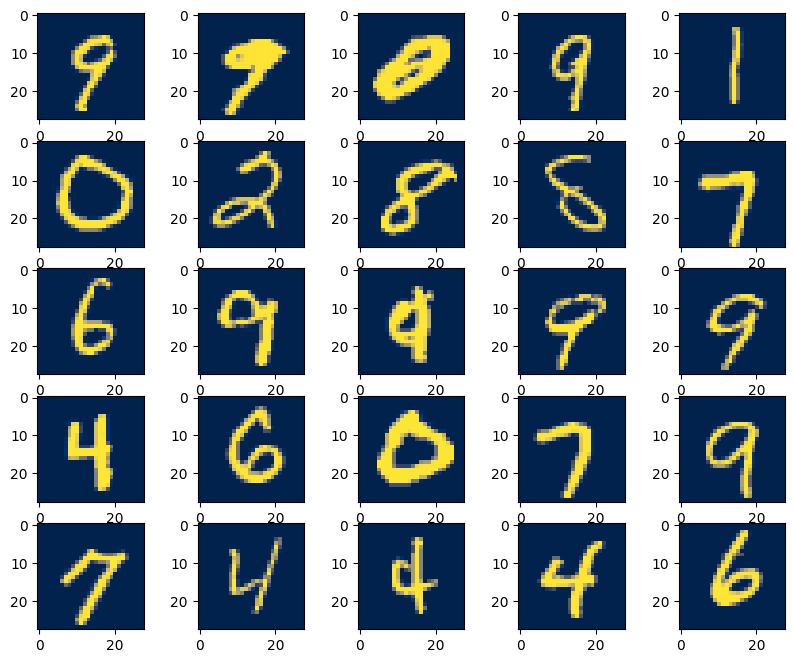

In [276]:
plt.figure(figsize=(10, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    idx = torch.randint(X_train.shape[0], (1,)).item()
    plt.imshow(X_train[idx], cmap='cividis')


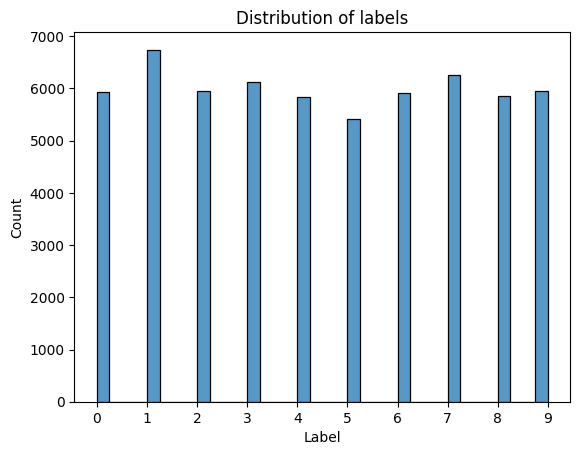

In [277]:
sns.histplot(y_train)
plt.xticks(torch.arange(0, len(set(y_train)), 1))
plt.title("Distribution of labels")
plt.ylabel("Count")
plt.xlabel("Label");

In [278]:
X_train = torch.tensor(X_train) / 255
X_test = torch.tensor(X_test) / 255
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)   

In [279]:
class MNISTData(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return (self.x[i], self.y[i])

In [280]:
train_data = DataLoader(MNISTData(X_train, y_train), BATCH_SIZE, shuffle=True)
test_data = DataLoader(MNISTData(X_test, y_test), BATCH_SIZE, shuffle=True)

In [281]:
class CNN(nn.Module):
    def __init__(self, in_dim, conv1_kernel_size, conv_pool_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_dim, in_dim, (conv1_kernel_size, conv1_kernel_size))
        self.pool1 = nn.AvgPool2d((conv_pool_size, conv_pool_size))
        self.conv2 = nn.Conv2d(in_dim, in_dim, (conv1_kernel_size, conv1_kernel_size))
        self.pool2 = nn.AvgPool2d((conv_pool_size, conv_pool_size))
        self.lin  = nn.Linear(25, len(set(y_train)))

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.pool1(out1)
        out3 = self.conv2(out2)
        out4 = self.pool2(out3)
        out5 = out4.flatten(1)
        output = self.lin(out5)
        return output

In [282]:
model = CNN(BATCH_SIZE, KERNEL_DIM, POOL_DIM)
optim = torch.optim.AdamW(model.parameters(), LEARNING_RATE)

In [283]:
def train_epoch():
    lossi = []
    for x, y in train_data:
        output = model(x)
        loss = F.cross_entropy(output, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        lossi.append(loss.item())

    return torch.tensor(lossi).mean().item()


@torch.no_grad
def val_epoch():
    lossi = []
    for x, y in test_data:
        output = model(x)
        loss = F.cross_entropy(output, y)
        lossi.append(loss.item())

    return torch.tensor(lossi).mean().item()

In [285]:
train_lossi, val_lossi = [], []
for epoch in range(EPOCHS):
    train_loss = train_epoch()
    val_loss = val_epoch()

    train_lossi.append(train_loss)
    val_lossi.append(val_loss)

    print(f"EPOCH: {epoch} |  TRAIN-LOSS: {train_loss} |  VAL-LOSS: {val_loss}")

EPOCH: 0 |  TRAIN-LOSS: 2.58146595954895 |  VAL-LOSS: 1.5353736877441406
EPOCH: 1 |  TRAIN-LOSS: 0.8728678822517395 |  VAL-LOSS: 0.5326182842254639
EPOCH: 2 |  TRAIN-LOSS: 0.4983704090118408 |  VAL-LOSS: 0.4440220296382904
EPOCH: 3 |  TRAIN-LOSS: 0.4444209635257721 |  VAL-LOSS: 0.41245195269584656
EPOCH: 4 |  TRAIN-LOSS: 0.424799382686615 |  VAL-LOSS: 0.39494788646698


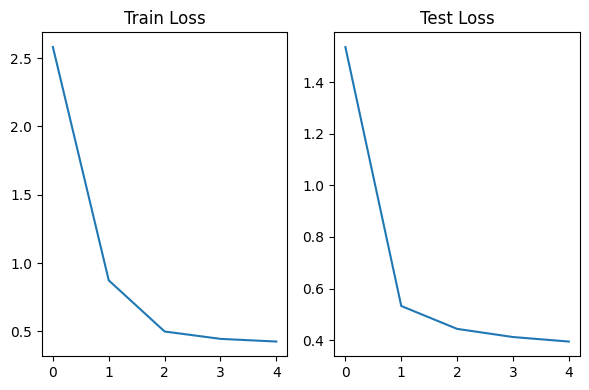

In [286]:
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.title("Train Loss")
plt.plot(train_lossi)
plt.subplot(1, 2, 2)
plt.title("Test Loss")
plt.plot(val_lossi)
plt.tight_layout()

In [292]:
acc = []
for x,y in train_data:
    cur_pred = model(x).argmax(dim=1)
    acc.append(accuracy_score(cur_pred, y))

print(f"Train Accuracy: {torch.tensor(acc).mean() * 100}%")


acc = []
for x,y in test_data:
    cur_pred = model(x).argmax(dim=1)
    acc.append(accuracy_score(cur_pred, y))

print(f"Test Accuracy: {torch.tensor(acc).mean() * 100}%")

Train Accuracy: 87.845%
Test Accuracy: 88.57000000000001%
